In [1]:
import scipy.io
import xarray as xr
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
path = f'/scratch/jw8736/mlflux/data/OOI/'

%load_ext autoreload
%autoreload 3

In [2]:
# ds.to_netcdf('output.nc')
ref = '/scratch/jw8736/mlflux/data/Processed/psd_coare3p0_weight1_wave0.nc'
ds_ref = xr.load_dataset(ref)

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [ ]:
from ooi_helper import convert_mat_to_xarray

In [ ]:

ds_ooi = []
filenames = ['Transfer_SouthernOcean_2_v3.mat', 'Transfer_CLIMODE_v3.mat', 'Transfer_Irminger_10_v3.mat',
             'Transfer_Endurance_9_v3.mat', 'Transfer_Pioneer_10_v3.mat']
for filename in filenames:
    mat_data = scipy.io.loadmat(path + filename, struct_as_record=False, squeeze_me=True)
    ds = convert_mat_to_xarray(mat_data)
    ds = clean(ds)
    ds_ooi.append(ds)

NameError: name 'convert_mat_to_xarray' is not defined

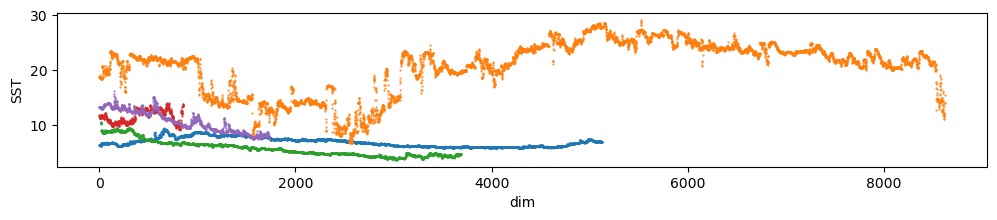

In [25]:
fig = plt.figure(figsize=(12,2))
for ds in ds_ooi:
    ds.SST.plot(marker='.',linestyle='None', markersize=1)

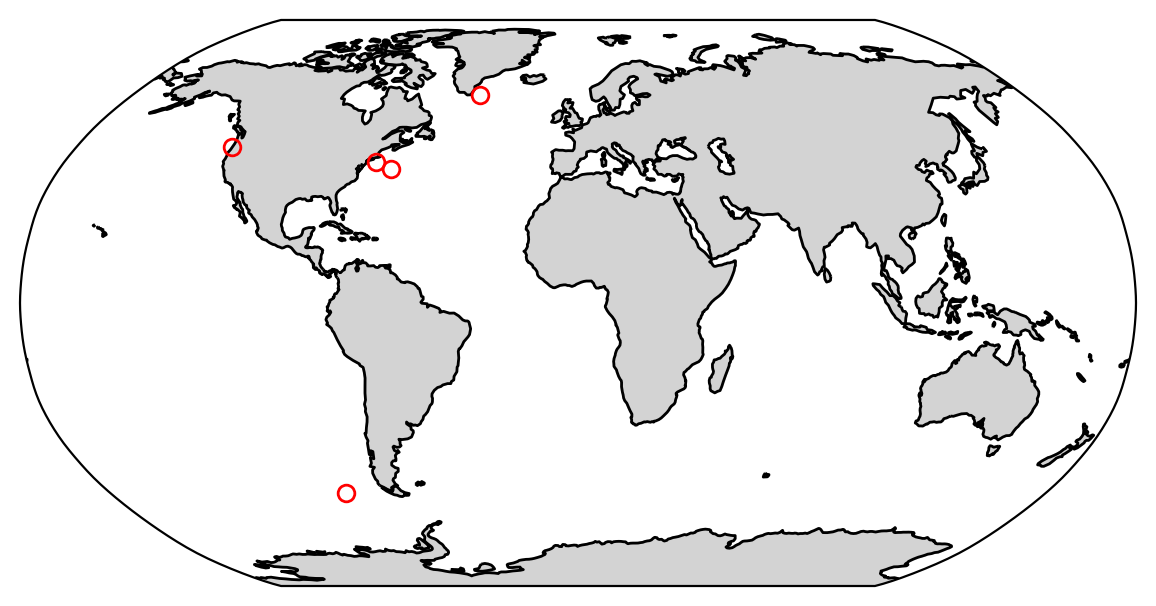

In [26]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

pcodes = {'77':'Metz', '67':'Calwater', '72':'HiWInGS', '78':'NEAQS', '73':'Capricorn', '71':'GasEx', 
          '69':'EPIC', '87':'WHOTS', '83':'Stratus', '68':'DYNAMO'}

pcode_ordered = [77, 67, 72, 78, 73, 71, 68, 83, 69, 87]

fig = plt.figure(figsize=(8,5), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
# ax.stock_img()
# ax.add_feature(cfeature.LAND, color='gainsboro')  # Dry land in tan color
ax.add_feature(cfeature.LAND, color='lightgray')  # Dry land in tan color
# ax.add_feature(cfeature.LAND, color='linen')  # Dry land in tan color
ax.coastlines()
colors = cm.tab10(np.linspace(0, 1, 10))

# lines = []
# labels = []
# for i, p in enumerate(pcode_ordered):
#     idx = ds_ref.pcode == p
#     pcode = pcodes[str(int(p))]
#     line = ax.scatter(ds_ref.lon[idx], ds_ref.lat[idx],
#                     s=1, color=colors[i], label='{}'.format(pcode), transform=ccrs.PlateCarree())
#     lines.append(line)
#     labels.append('{}'.format(pcode))
    
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

for ds in ds_ooi:
    line = ax.plot(ds.lon.isel(dim=0), ds.lat.isel(dim=0), marker='o', markerfacecolor='none',
                   markersize=6, color='red', transform=ccrs.PlateCarree())

# First row with 3 items
# legend1 = ax.legend(handles=lines[:1], labels=labels[:1], loc='upper left',
#                     bbox_to_anchor=(0.1, -0.05), alignment='center', fontsize=10, ncol=1, frameon=False)
# legend2 = ax.legend(handles=lines[1:4], labels=labels[1:4], loc='upper left',
#                     bbox_to_anchor=(0.3, -0.05), alignment='center', fontsize=10, ncol=1, frameon=False)
# legend3 = ax.legend(handles=lines[4:6], labels=labels[4:6], loc='upper left',
#                     bbox_to_anchor=(0.5, -0.05), alignment='center', fontsize=10, ncol=1, frameon=False)
# legend4 = ax.legend(handles=lines[6:10], labels=labels[6:10], loc='upper left',
#                     bbox_to_anchor=(0.7, -0.05), alignment='center', fontsize=10, ncol=1, frameon=False)

# # leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, ncol=2, fontsize=10)

# ax.add_artist(legend1)
# ax.add_artist(legend2)
# ax.add_artist(legend3)

# for leg in (legend1, legend2, legend3, legend4):
#     for handle in leg.legendHandles:
#         handle.set_sizes([25])

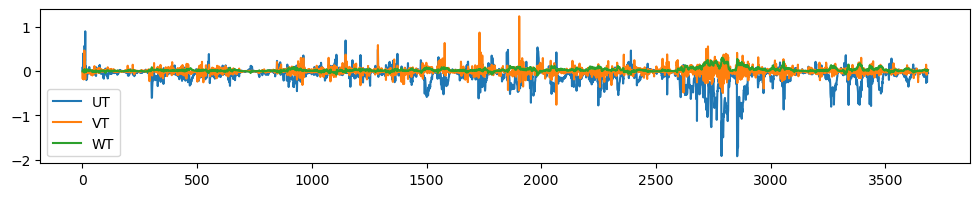

In [23]:
fig = plt.figure(figsize=[12,2])
plt.plot(ds_ooi.UT, label='UT')
plt.plot(ds_ooi.VT, label='VT')
plt.plot(ds_ooi.WT, label='WT')
plt.legend()

In [2]:
from mlflux.eval import open_case

LH_dir = f'/scratch/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
SH_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
M_dir  = f'/scratch/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
rand_seed = 4 # choose the one random seed where loss curves look good

dir = M_dir
model_M = open_case (dir, 'model_rand%g.p' %rand_seed)
# plot_corr (ax, model, ds, subsample=1000)

dir = SH_dir
model_SH = open_case (dir, 'model_rand%g.p' %rand_seed)
# plot_corr (ax, model, ds, subsample=1000)

dir = LH_dir
model_LH = open_case (dir, 'model_rand%g.p' %rand_seed)
# plot_corr (ax, model, ds, subsample=1000)

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [9]:
total_params = sum(p.numel() for p in model_LH.mean_func.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 737


In [40]:
from mlflux.ann import RealFluxDataset

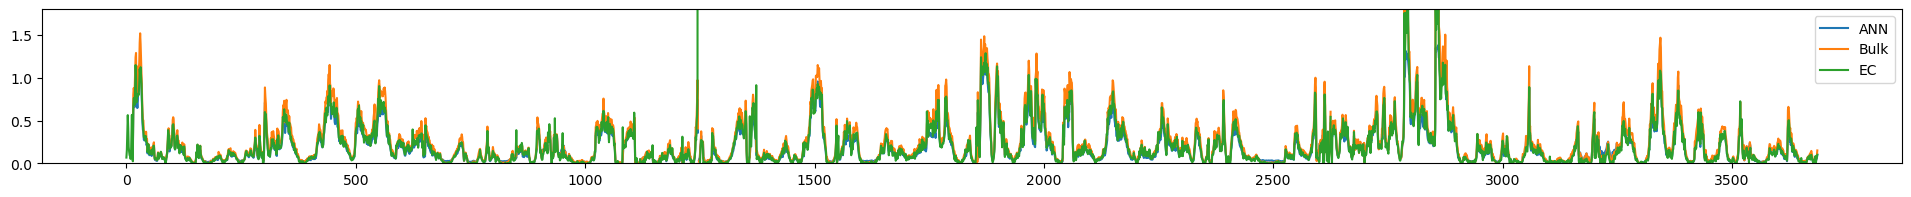

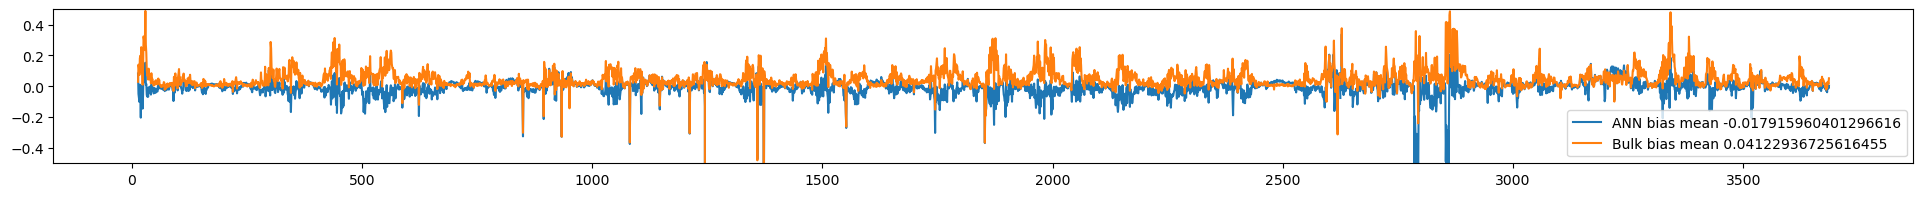

In [52]:
### Momentum
ikeys = ['Ue', 'SST', 'Tair', 'RH', 'Pair']
okeys = ['UW']
bkeys = ['stress']
vd = RealFluxDataset(ds_ooi, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
Ypred_mean = model_M.pred_mean(vd.X)
Ypred_var = model_M.pred_var(vd.X)

fig = plt.figure(figsize=[24, 2])
plt.plot(Ypred_mean.detach().numpy(), label=f'ANN')
plt.plot(vd.Bulk, label=f'Bulk')
plt.plot(-vd.Y, label=f'EC')
plt.ylim([0, 1.8])
plt.legend()

fig = plt.figure(figsize=[24, 2])
bias = Ypred_mean.detach().numpy() + vd.Y.detach().numpy()
plt.plot(bias, label=f'ANN bias mean {np.nanmean(bias)}')
bias = vd.Bulk.detach().numpy() + vd.Y.detach().numpy()
plt.plot(bias, label=f'Bulk bias mean {np.nanmean(bias)}')
plt.ylim([-0.5, 0.5])
plt.legend()

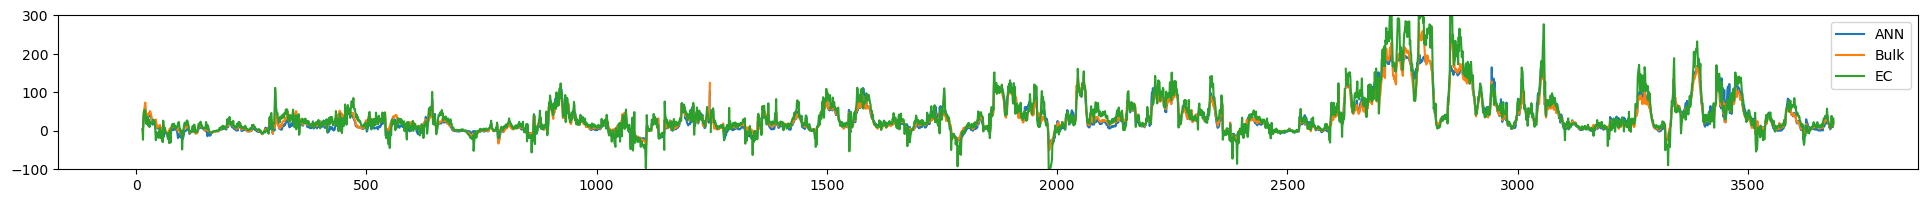

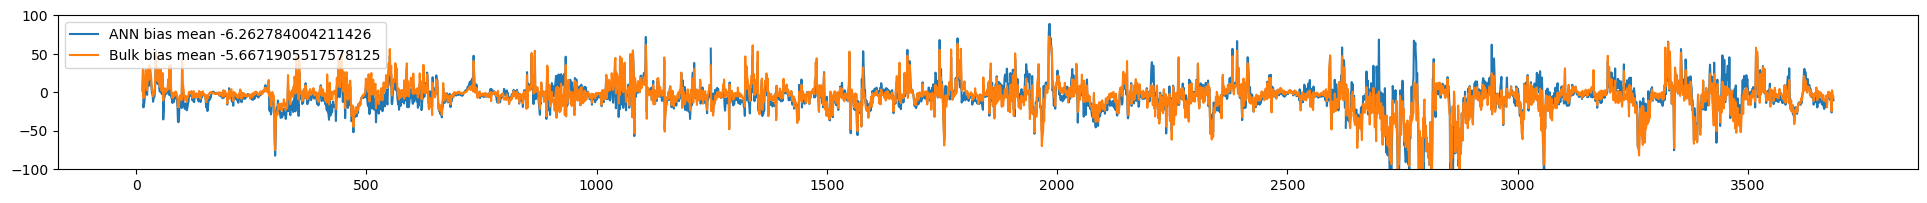

In [48]:
### Heat 
ikeys = ['Ue', 'SST', 'Tair', 'RH', 'Pair']
okeys = ['SH']
bkeys = ['shf']
vd = RealFluxDataset(ds_ooi, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
Ypred_mean = model_SH.pred_mean(vd.X)
Ypred_var = model_SH.pred_var(vd.X)

fig = plt.figure(figsize=[24, 2])
plt.plot(-Ypred_mean.detach().numpy(), label=f'ANN')
plt.plot(vd.Bulk, label=f'Bulk')
plt.plot(vd.Y, label=f'EC')
plt.ylim([-100, 300])
plt.legend()

fig = plt.figure(figsize=[24, 2])
bias = - Ypred_mean.detach().numpy() - vd.Y.detach().numpy()
plt.plot(bias, label=f'ANN bias mean {np.nanmean(bias)}')
bias = vd.Bulk.detach().numpy() - vd.Y.detach().numpy()
plt.plot(bias, label=f'Bulk bias mean {np.nanmean(bias)}')
plt.ylim([-100, 100])
plt.legend()

In [ ]:
''' First evaluate on the whole data set. '''
vd = RealFluxDataset(ds, input_keys=model.config['ikeys'], 
                     output_keys=model.config['okeys'], bulk_keys=model.config['bkeys'])
# [ann_mse, ann_r2, res_mean, res_var, wd, bulk_mse, bulk_r2]
scores = evaluate (model, ds, WEIGHT=model.config['WEIGHT'])

''' Then subsample for visualization. '''    
if subsample != None:        
    if model.config['WEIGHT']:
        w_index = np.random.choice(len(vd.X), subsample, p=vd.W.squeeze()/vd.W.sum())
    else:
        w_index = np.random.choice(len(vd.X), subsample)
    vd.X = vd.X[w_index,:]; vd.Y = vd.Y[w_index,:]; vd.Bulk = vd.Bulk[w_index,:]
    
Ypred_mean = model.pred_mean(vd.X)

cbulk = 'k'
cann = 'C1'
if model.config['okeys'] == ['hlc']:
    ax.set_ylim([-250,50]); ax.set_xlim([-250,50])
    ax.set_yticks([-250,-150,-50,0,50])
    ax.set_xticks([-250,-150,-50,0,50])
    ax.set_xlabel(r'Measurement $Q_{L,c} \; [W/m^2]$')
    # ax.set_ylabel(r'Prediction $[W/m^2]$')
    ax.plot(vd.Y, vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, 
            label=r'$Q_{L,b}$ ($R^2$=%.2f)' %scores[-1], c=cbulk)
    ax.plot(vd.Y, Ypred_mean.detach().numpy(), 'o', mfc="None", markeredgewidth=0.5, markersize=4, 
            label=r'$\mu_{Q_L}$ ($R^2$=%.2f)' %scores[1], c=cann)

In [12]:
ds_ooi

<xarray.Dataset>
Dimensions:    (dim: 4689)
Dimensions without coordinates: dim
Data variables: (12/84)
    Beta       (dim) float64 3.886 3.631 3.274 3.065 ... 4.005 3.734 3.551 3.869
    BetaRaw    (dim) float64 7.047 7.403 7.792 7.353 ... 6.904 6.794 6.659 7.281
    Bf         (dim) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    BfT        (dim) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    CE         (dim) float64 nan nan nan nan ... -0.0212 -0.04895 -0.01422
    CN         (dim) float64 nan nan nan nan ... 0.01678 0.05725 0.03891 0.0361
    ...         ...
    yday       (dim) float64 244.0 244.1 244.1 244.1 ... 439.5 439.6 439.6 439.6
    yyyy       (dim) uint16 2023 2023 2023 2023 2023 ... 2024 2024 2024 2024
    zi         int64 600
    zq         float64 5.255
    zt         float64 5.255
    zu         float64 5.85